# Efficient Economic Scenario Generation - Vectorised Numpy Approach

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import jax
import jax.numpy as jnp
from cProfile import Profile

## The Numpy Approach

### Defining Our Model

In [2]:
def correlate_weiner_process_npy(X, rho, dt):
    corr = np.array([[1,rho],[rho,1]])
    L = np.linalg.cholesky(corr)
    # dZ = np.sqrt(dt)*(np.einsum('ij,ikl -> ikl',L,X))
    dZ = np.sqrt(dt)* np.tensordot(L,X, axes=([1],[0]))
    return dZ

def get_drift_npy(x, alpha, mu, dt):
    # return np.einsum('ij,ij -> ij', alpha, (mu-x)) * dt
    return alpha * (mu-x) * dt

def get_diffusion_npy(x, sigma, dZ):
    # return np.einsum('ij,ij->ij', np.einsum('ij,ij->ij',sigma,np.sqrt(x)),dZ)
    return sigma * np.sqrt(x) * dZ

def update_npy(x, alpha, mu, sigma, dt, dZ):
    return x + get_drift_npy(x, alpha, mu, dt) + get_diffusion_npy(x, sigma, dZ)

def generate_processes_npy(x0, dt, alpha, mu, sigma, dZ):
    x = np.zeros(dZ.shape)
    x[:, 0] = x0

    for i in range(1, 1200):
        x[:, i] = update_npy(x[:, i-1], alpha, mu, sigma, dt, dZ[:, i-1])

        
    xt1 = np.sum(x,axis=0)
    phi = 0.045 - np.expand_dims(np.sum(x0,axis=0), axis=0)
    
    n = phi + xt1
    return n


### Setting Parameters

In [3]:
n_trials = 100_000

n_years = 100
dt = 1/12
n_factors = 2
rho = 0.739

x0 = np.array([np.repeat(0.0228, n_trials),np.repeat(0.0809, n_trials)])
alpha = np.array([np.repeat(1.0682, n_trials), np.repeat(0.0469,n_trials)])
mu = np.array([np.repeat(0.0546, n_trials), np.repeat(0.0778, n_trials)])
sigma = np.array([np.repeat(0.0412, n_trials), np.repeat(0.0287, n_trials)])

### Generating Scenarios

In [4]:
key = jax.random.PRNGKey(57)
X = jax.random.normal(key=key, shape=(n_factors, int(n_years / dt), n_trials))


start = time.time()
dZ = correlate_weiner_process_npy(X, rho, dt)
end1 = time.time()
print("Time taken for calculating Weiner process correlations: ", end1 - start)

2024-04-25 14:34:59.401459: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 3.28GiB (3519065080 bytes) by rematerialization; only reduced to 3.58GiB (3840000016 bytes), down from 3.58GiB (3840000016 bytes) originally


Time taken for calculating Weiner process correlations:  1.6141769886016846


In [5]:
with Profile() as prof:
    n_npy = generate_processes_npy(x0, dt, alpha, mu, sigma, dZ)
    prof.print_stats(sort='tottime')

         4130 function calls (4120 primitive calls) in 2.012 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1199    0.562    0.000    0.562    0.000 2735840555.py:12(get_diffusion_npy)
     1199    0.453    0.000    0.453    0.000 2735840555.py:8(get_drift_npy)
        1    0.387    0.387    1.809    1.809 2735840555.py:19(generate_processes_npy)
        2    0.355    0.178    0.355    0.178 {method 'reduce' of 'numpy.ufunc' objects}
     1199    0.215    0.000    1.230    0.001 2735840555.py:16(update_npy)
        5    0.029    0.006    2.204    0.441 base_events.py:1910(_run_once)
      5/2    0.007    0.001    0.000    0.000 events.py:86(_run)
        2    0.002    0.001    0.002    0.001 {method '__exit__' of 'sqlite3.Connection' objects}
        1    0.000    0.000    0.002    0.002 history.py:845(writeout_cache)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
      

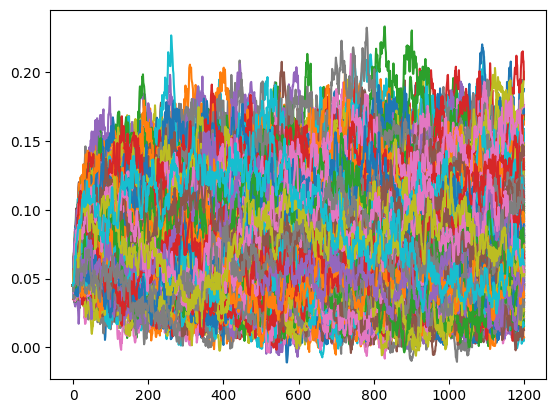

In [6]:
plt.plot(n_npy[:, :1000]);

## The Jax Approach

In [7]:
# Check Jax uses GPU

print(jax.devices())

[cuda(id=0)]


### Defining Our Model

In [8]:
def correlate_weiner_process_jax(X, rho, dt):
    corr = jnp.array([[1,rho],[rho,1]])
    L = jnp.linalg.cholesky(corr)
    dZ = jnp.sqrt(dt)*jnp.tensordot(L, X, axes=([1],[0]))
    # dZ = jnp.sqrt(dt)*(jnp.einsum('ij,ikl -> jkl',L,X))
    return dZ

def get_drift_jax(x, alpha, mu, dt):
    # return jnp.einsum('ij,ij -> ij', alpha, (mu-x)) * dt
    return alpha * (mu - x) * dt

def get_diffusion_jax(x, sigma, dZ):
    # return jnp.einsum('ij,ij->ij', jnp.einsum('ij,ij->ij',sigma, jnp.sqrt(x)),dZ)
    return sigma * jnp.sqrt(x) * dZ

def update_jax(x, alpha, mu, sigma, dt, dZ):
    return x + get_drift_jax(x, alpha, mu, dt) + get_diffusion_jax(x, sigma, dZ)

def generate_processes_jax(x0, dt, alpha, mu, sigma, dZ):
    x = jnp.zeros(dZ.shape)
    x = x.at[:, 0].set(x0)

    update_jax_jit = jax.jit(update_jax)
    for i in range(1, dZ.shape[1]):
        x = x.at[:, i].set(update_jax_jit(x[:, i-1], alpha, mu, sigma, dt, dZ[:, i-1]))
        
    xt1 = jnp.sum(x,axis=0)
    phi = 0.045 - jnp.expand_dims(jnp.sum(x0,axis=0), axis=0)
    
    n = phi + xt1
    return n


### Setting Parameters

In [9]:
n_trials = 10_000

n_years = 100
dt = 1/12
n_factors = 2
rho = 0.739

x0 = jnp.array([jnp.repeat(0.0228, n_trials),jnp.repeat(0.0809, n_trials)])
alpha = jnp.array([jnp.repeat(1.0682, n_trials), jnp.repeat(0.0469,n_trials)])
mu = jnp.array([jnp.repeat(0.0546, n_trials), jnp.repeat(0.0778, n_trials)])
sigma = jnp.array([jnp.repeat(0.0412, n_trials), jnp.repeat(0.0287, n_trials)])

### Generating Scenarios

In [10]:
key = jax.random.PRNGKey(57)
X = jax.random.normal(key=key, shape=(n_factors, int(n_years / dt), n_trials))

start = time.time()
dZ = correlate_weiner_process_jax(X, rho, dt)
end1 = time.time()
print("Time taken for calculating Weiner process correlations: ", end1 - start)

Time taken for calculating Weiner process correlations:  0.2049856185913086


In [11]:
with Profile() as prof:
    n_jax = generate_processes_jax(x0, dt, alpha, mu, sigma, dZ)
    prof.print_stats(sort='tottime')

         2456127 function calls (2389625 primitive calls) in 2.251 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   8393/0    0.474    0.000    0.000          dispatch.py:79(apply_primitive)
       12    0.151    0.013    0.151    0.013 compiler.py:215(backend_compile)
    37287    0.118    0.000    0.235    0.000 dtypes.py:644(dtype)
    65165    0.105    0.000    0.196    0.000 dtypes.py:329(issubdtype)
457829/457823    0.083    0.000    0.113    0.000 {built-in method builtins.isinstance}
   2397/0    0.070    0.000    0.000          lax_numpy.py:4503(_attempt_rewriting_take_via_slice)
   172673    0.055    0.000    0.081    0.000 config.py:275(value)
   1199/0    0.047    0.000    0.000          lax_numpy.py:887(squeeze)
   8421/0    0.041    0.000    0.000          lax.py:518(_convert_element_type)
   1199/0    0.035    0.000    0.000          lax_numpy.py:4718(_index_to_gather)
     3600    0.033    0.000    0.282  

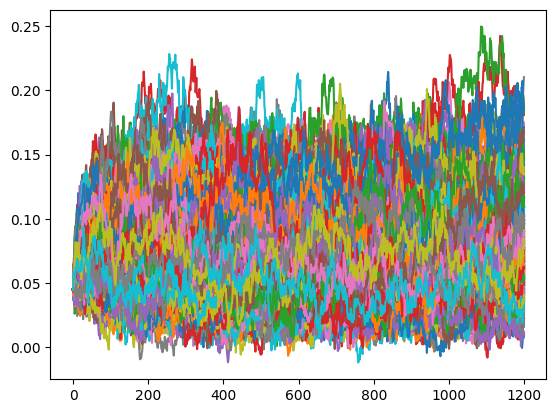

In [12]:
plt.plot(n_jax[:, :1000]);

## Benchmarking!
To examine how efficient our approaches are at scenario generation we'll be comparing 6 options over an exponentially increasing number of runs. The options we'll be including for benchmarking are:
- PYESG
- Our Numpy approach.
- Our JAX approach with Just in Time (JIT) compilation on a CPU.
- Our JAX approach with Just in Time (JIT) compilation on a GPU.
- Our Cython approach.

Benchmarking is being performed on a Dell G15 5510 laptop running Arch Linux with kernel version 6.8.5-arch1-1 with the following computational resources:
- 16 × Intel® Core™ i7-10870H CPU @ 2.20GHz
- 31.1 GiB of RAM 
- NVIDIA GeForce RTX 3060

In [13]:
# make a version of the function which uses jit but runs on cpu, and another for gpu
generate_processes_jax_jit_cpu = jax.jit(generate_processes_jax, backend='cpu')
generate_processes_jax_jit_gpu = jax.jit(generate_processes_jax, backend='gpu')

In [14]:

def benchmark_cir(models, trials, n_years, dt, n_factors, rho, x0, alpha, mu, sigma, key):

    times = {}
    for trials in n_trials:
        x0 = jnp.array([jnp.repeat(x0[0], trials),jnp.repeat(x0[1], trials)])
        alpha = jnp.array([jnp.repeat(alpha[0], trials), jnp.repeat(alpha[1],trials)])
        mu = jnp.array([jnp.repeat(mu[0], trials), jnp.repeat(mu[1], trials)])
        sigma = jnp.array([jnp.repeat(sigma[0], trials), jnp.repeat(sigma[1], trials)])

        X = jax.random.normal(key=key, shape=(n_factors, int(n_years / dt), trials))
        dz = correlate_weiner_process_jax(X, rho, dt).block_until_ready()
        for model in models:
            start = time.time()
            n = model(x0, dt, alpha, mu, sigma, dz)
            end = time.time()
            print(f"Time taken for {model.__name__} with {trials} trials: ", end - start)
            times[model.__name__ + trials] = end - start
    
    return times

Time taken for generate_processes_npy with 1 trials:  0.9385130405426025
Time taken for generate_processes_jax with 1 trials:  1.396719217300415
Time taken for generate_processes_jax with 1 trials:  70.77989673614502
Time taken for generate_processes_jax with 1 trials:  0.0006430149078369141
Time taken for generate_processes_jax with 1 trials:  131.19221472740173
Time taken for generate_processes_jax with 1 trials:  0.0048215389251708984
Time taken for generate_processes_npy with 10 trials:  0.9570441246032715
Time taken for generate_processes_jax with 10 trials:  1.3791029453277588


2024-04-25 14:40:46.909858: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_generate_processes_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-25 14:42:16.054537: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m29.144745098s

********************************
[Compiling module jit_generate_processes_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Time taken for generate_processes_jax with 10 trials:  214.86178827285767
Time taken for generate_processes_jax with 10 trials:  0.0046520233154296875
Time taken for generate_processes_jax with 10 trials:  144.71971201896667
Time taken for generate_processes_jax with 10 trials:  0.0036094188690185547
Time taken for generate_processes_npy with 100 trials:  0.9492106437683105
Time taken for generate_processes_jax with 100 trials:  1.372969627380371


2024-04-25 14:49:02.912751: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m14.306037815s

********************************
[Compiling module jit_generate_processes_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Time taken for generate_processes_jax with 100 trials:  259.6883373260498
Time taken for generate_processes_jax with 100 trials:  0.03632688522338867
Time taken for generate_processes_jax with 100 trials:  109.66351699829102
Time taken for generate_processes_jax with 100 trials:  0.0033550262451171875
Time taken for generate_processes_npy with 1000 trials:  0.9852211475372314
Time taken for generate_processes_jax with 1000 trials:  1.3659937381744385


2024-04-25 14:55:00.672004: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m0.127251458s

********************************
[Compiling module jit_generate_processes_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Time taken for generate_processes_jax with 1000 trials:  246.38226008415222
Time taken for generate_processes_jax with 1000 trials:  0.9541525840759277
Time taken for generate_processes_jax with 1000 trials:  111.20418047904968
Time taken for generate_processes_jax with 1000 trials:  0.003294706344604492
Time taken for generate_processes_npy with 10000 trials:  1.0417766571044922
Time taken for generate_processes_jax with 10000 trials:  1.2226274013519287


2024-04-25 14:59:01.398035: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_generate_processes_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
n_trials = [1*10**(i) for i in range(6)]

n_years = 100
dt = 1/12
n_factors = 2
rho = 0.739

x0 = jnp.array([0.0228, 0.0809])
alpha = jnp.array([1.0682, 0.0469])
mu = jnp.array([0.0546, 0.0778])
sigma = jnp.array([0.0412, 0.0287])

key = jax.random.PRNGKey(57)

models = [generate_processes_npy, 
          generate_processes_jax, 
          generate_processes_jax_jit_cpu, 
          generate_processes_jax_jit_cpu, 
          generate_processes_jax_jit_gpu, 
          generate_processes_jax_jit_gpu]

times = benchmark_cir(models, n_trials, n_years, dt, n_factors, rho, x0, alpha, mu, sigma, key)
